In [1]:
import requests
import re
from bs4 import BeautifulSoup as bs
import pandas as pd
import datetime as dt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ValueError: mount failed

In [ ]:
df_ready = pd.read_csv('drive/My Drive/df_ready.csv')
pd.set_option('display.max_columns', None)
#df_ready

In [ ]:
#geyma odds
odds = df_ready[['OddsH','OddsA','OddsD']]

In [ ]:
#skoða class imbalance og vigta aðeins, gæti aðstoðað að bæta spágetuna á jafnteflum, ef ekki má spá í Home Win eða ekki líkani.

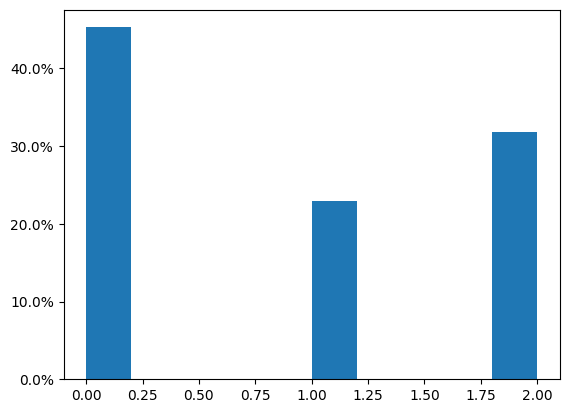

In [ ]:
#histogram home win draw away win
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

data = df_ready["winner"]

plt.hist(data, weights=np.ones(len(data)) / len(data))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

#ekkert brjálæðislega imbalanced en samt missir módelið af fullt af jafnteflum

In [ ]:
#gæti prófað að resampla datasettið, over eða undersampla
df_ready = df_ready.dropna(inplace=False)

In [ ]:
df_ready

,Unnamed: 0,GameId,HomeTeam,AwayTeam,HomeGoals,AwayGoals,HomexG,AwayxG,GW,HTGS,ATGS,HTGC,ATGC,HTxGS,ATxGS,HTxGC,ATxGC,winner,glicko_diff,target,HTP,ATP,Date,Half Time Result,HomeShots,AwayShots,HomeShotOT,AwayShotsOT,HomeFouls,AwayFouls,HomeCorners,AwayCorners,OddsH,OddsD,OddsA,HalfTimeResult,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HomeStrength,AwayStrength,HomexGStrength,AwayxGStrength,HomeGoals_ema,AwayGoals_ema,HomexG_ema,AwayxG_ema,HomeShots_ema,AwayShots_ema,HomeShotsOT_ema,AwayShotsOT_ema,HomeCorners_ema,AwayCorners_ema,HomeFouls_ema,AwayFouls_ema,HomeGoals_5ma,AwayGoals_5ma,HomexG_5ma,AwayxG_5ma,HomeShots_5ma,AwayShots_5ma,HomeShotsOT_5ma,AwayShotsOT_5ma,HomeCorners_5ma,AwayCorners_5ma,HomeFouls_5ma,AwayFouls_5ma
0,20,21,Tottenham,Liverpool,1,1,0.590511,1.925690,3,2,4,1,5,3.379710,2.598125,1.148006,1.379506,1,94.976995,D,4,3,27/08/16,2,11,13,4,3,5,5,11,17,0.420168,0.294118,0.333333,0,WD---,LW---,4,3,2.000000,0.800000,2.943983,1.883373,1.000000,4.000000,1.123480,1.659100,13.000000,16.000000,4.000000,7.000000,14.000000,17.000000,8.052632,8.105263,1.0,2.0,1.689855,1.299063,16.5,21.0,4.5,6.0,16.5,11.0,8.0,8.0
1,21,22,Watford,Arsenal,1,3,1.077750,2.032710,3,2,3,3,4,0.984595,1.703479,2.693278,2.212793,2,99.545073,L,1,1,27/08/16,2,14,10,6,7,3,2,18,15,0.200000,0.266667,0.578035,0,LD---,DL---,1,1,0.666667,0.750000,0.365575,0.769832,3.000000,1.000000,1.181970,0.180046,9.000000,5.000000,5.000000,1.000000,13.000000,12.000000,6.026316,0.973684,1.5,1.0,0.851739,0.492297,11.0,5.5,4.5,1.5,10.0,16.0,6.0,1.0
2,22,23,Leicester,Swansea,2,1,2.479770,0.328180,3,1,1,2,2,3.010003,2.862230,1.261527,3.235580,0,-389.810305,W,1,3,27/08/16,0,13,9,6,3,4,6,14,10,0.578035,0.277778,0.190476,2,DL---,LW---,1,3,0.500000,0.500000,2.386000,0.884611,1.000000,1.000000,2.456310,1.720890,18.000000,17.000000,5.000000,9.000000,17.000000,14.000000,2.486842,6.052632,0.5,0.5,1.505002,1.431115,13.0,15.0,3.0,6.0,14.0,10.5,2.5,6.0
3,23,24,Southampton,Sunderland,1,1,0.613743,1.391420,3,1,2,3,4,1.550561,2.563270,1.545576,2.809698,1,291.214422,D,1,0,27/08/16,1,16,5,7,2,5,5,15,8,0.636943,0.277778,0.153846,1,LD---,LL---,1,0,0.333333,0.500000,1.003225,0.912294,1.000000,1.000000,1.098770,0.937328,7.000000,24.000000,3.000000,6.000000,14.000000,8.000000,7.026316,2.921053,1.0,0.5,1.281635,0.775281,12.5,18.5,4.0,3.5,12.5,8.0,7.0,3.0
4,24,25,Chelsea,Burnley,3,0,2.658380,0.184490,3,4,2,2,1,3.216250,1.246566,1.250153,2.659915,0,579.575171,W,6,3,27/08/16,0,22,6,10,0,9,5,6,9,0.800000,0.181818,0.066667,2,WW---,WL---,6,3,2.000000,2.000000,2.572685,0.468649,2.000000,0.000000,1.460300,1.049030,16.000000,10.000000,6.000000,3.000000,16.000000,10.000000,5.973684,3.921053,2.0,1.0,1.608125,0.623283,14.5,6.5,5.0,2.5,13.0,12.0,6.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2558,2655,2656,Everton,Bournemouth,1,0,1.129330,0.432084,38,33,37,57,70,47.520506,39.651881,68.150778,66.472764,0,-324.743046,W,33,39,28/05/2023,1,13,7,6,2,9,3,11,12,0.666667,0.222222,0.153846,1,DLWDL,LLLWW,5,6,0.578947,0.528571,0.697285,0.596513,1.101215,1.034072,1.207696,1.352267,10.201945,11.470322,3.668023,4.117969,10.289971,10.716182,4.063956,4.446944,1.2,1.8,1.160216,2.132290,10.6,14.4,3.4,5.0,10.0,11.0,3.6,5.6
2559,2656,2657,Leeds,Tottenham,1,4,1.191510,2.033150,38,47,66,74,62,46.604455,55.800640,67.547883,50.469218,2,-585.675144,L,31,57,28/05/2023,2,19,11,2,7,12,3,7,5,0.363636,0.263158,0.434783,0,LDLLD,LLWLD,2,4,0.635135,1.064516,0.689947,1.105637,1.782436,1.246224,1.521903,1.265283,13.015145,11.746191,4.897676,3.882458,11.431418,12.239474,5.118106,4.792627,1.6,1.2,1.556006,1.247156,12.6,10.6,5.4,3.6,10.8,14.2,5.4,3.4
2560,2657,2658,Leicester,West Ham,2,1,2.030130,0.970352,38,49,41,67,53,46.956869,50.240380,58.818999,53.282043,0,-33.584483,W,31,40,28/05/2023,0,13,16,4,3,3,5,8,10,0

In [ ]:
#gerum diffdf_ready
df_ready['Goals_ema_diff'] = df_ready['HomeGoals_ema'] - df_ready['AwayGoals_ema']
df_ready['xG_ema_diff'] = (df_ready['HomexG_ema'] - df_ready['AwayxG_ema'])
df_ready['Shots_ema_diff'] = df_ready['HomeShots_ema'] - df_ready['AwayShots_ema']
df_ready['ShotsOT_ema_diff'] = df_ready['HomeShotsOT_ema'] - df_ready['AwayShotsOT_ema']
df_ready['Corners_ema_diff'] = (df_ready['HomeCorners_ema'] - df_ready['AwayCorners_ema'])
df_ready['Fouls_ema_diff'] = df_ready['HomeFouls_ema'] - df_ready['AwayFouls_ema']
df_ready['Form_diff'] = (df_ready['HTFormPts'] - df_ready['ATFormPts'])
df_ready['Goals_5ma_diff'] = df_ready['HomeGoals_5ma'] - df_ready['AwayGoals_5ma']
df_ready['xG_5ma'] = df_ready['HomexG_5ma'] - df_ready['AwayxG_5ma']
df_ready['Shots_5ma_diff'] = df_ready['HomeShots_5ma'] - df_ready['AwayShots_5ma']
df_ready['Corners_5ma_diff'] = (df_ready['HomeCorners_5ma'] - df_ready['AwayCorners_5ma'])
df_ready['ShotsOT_5ma_diff'] = df_ready['HomeShotsOT_5ma'] - df_ready['AwayShotsOT_5ma']
df_ready['Fouls_5ma_diff'] = df_ready['HomeFouls_5ma'] - df_ready['AwayFouls_5ma']
df_ready['Strength_diff'] = df_ready['HomeStrength'] - df_ready['AwayStrength']
df_ready['xGStrength_diff'] = df_ready['HomexGStrength'] - df_ready['AwayxGStrength']

In [ ]:
# próf líka test lable is home win
def home_win(HomeWin):
  HomeWin['HomeWin'] = 0
  HomeWin['HomeWin'][HomeWin['HomeGoals'] > HomeWin['AwayGoals']] = 1
  return HomeWin

df_ready = home_win(df_ready)

In [ ]:
#setjum upp X dataframe, ema stats + form.
#búum líka til test og train skiptingu, season 21/22 er train

X_df = df_ready.filter(['Goals_ema_diff',
                        'xG_ema_diff',
                        'Shots_ema_diff',
                        'ShotsOT_ema_diff',
                        'Corners_ema_diff',
                        'Fouls_ema_diff',
                        'Goals_5ma_diff',
                        'xG_5ma',
                        'Shots_5ma_diff',
                        'ShotsOT_5ma_diff',
                        'Corners_5ma_diff',
                        'Fouls_5ma_diff',
                        'Points_diff',
                        'Strength_diff',
                        'xGStrength_diff',
                        'Form_diff',
                        'glicko_diff',
                        #'Half Time Result', ólöglegt eins og er, þarf að passa þar sem breytur eru shifted...
                        'OddsH', 'OddsD', 'OddsA'
                        ], axis=1)

y_df = df_ready.filter(['winner'], axis=1)
# = df_ready.filter(['HomeWin'], axis=1)

In [ ]:
#test til að skoða hvar á að splitta train og test
temp1 = df_ready.iloc[0:2212]
temp2 = df_ready.iloc[2212:2570]

In [ ]:
temp1

,Unnamed: 0,GameId,HomeTeam,AwayTeam,HomeGoals,AwayGoals,HomexG,AwayxG,GW,HTGS,ATGS,HTGC,ATGC,HTxGS,ATxGS,HTxGC,ATxGC,winner,glicko_diff,target,HTP,ATP,Date,Half Time Result,HomeShots,AwayShots,HomeShotOT,AwayShotsOT,HomeFouls,AwayFouls,HomeCorners,AwayCorners,OddsH,OddsD,OddsA,HalfTimeResult,HTFormPtsStr,ATFormPtsStr,HTFormPts,ATFormPts,HomeStrength,AwayStrength,HomexGStrength,AwayxGStrength,HomeGoals_ema,AwayGoals_ema,HomexG_ema,AwayxG_ema,HomeShots_ema,AwayShots_ema,HomeShotsOT_ema,AwayShotsOT_ema,HomeCorners_ema,AwayCorners_ema,HomeFouls_ema,AwayFouls_ema,HomeGoals_5ma,AwayGoals_5ma,HomexG_5ma,AwayxG_5ma,HomeShots_5ma,AwayShots_5ma,HomeShotsOT_5ma,AwayShotsOT_5ma,HomeCorners_5ma,AwayCorners_5ma,HomeFouls_5ma,AwayFouls_5ma,Goals_ema_diff,xG_ema_diff,Shots_ema_diff,ShotsOT_ema_diff,Corners_ema_diff,Fouls_ema_diff,Form_diff,Goals_5ma_diff,xG_5ma,Shots_5ma_diff,Corners_5ma_diff,ShotsOT_5ma_diff,Fouls_5ma_diff,Strength_diff,xGStrength_diff,HomeWin
0,20,21,Tottenham,Liverpool,1,1,0.590511,1.925690,3,2,4,1,5,3.379710,2.598125,1.148006,1.379506,1,94.976995,D,4,3,27/08/16,2,11,13,4,3,5,5,11,17,0.420168,0.294118,0.333333,0,WD---,LW---,4,3,2.000000,0.80,2.943983,1.883373,1.000000,4.000000,1.123480,1.659100,13.000000,16.000000,4.000000,7.000000,14.000000,17.000000,8.052632,8.105263,1.0,2.0,1.689855,1.299063,16.5,21.0,4.5,6.0,16.5,11.0,8.0,8.0,-3.000000,-0.535620,-3.000000,-3.000000,-3.000000,-0.052632,1,-1.0,0.390793,-4.5,5.5,-1.5,0.0,1.200000,1.060609,0
1,21,22,Watford,Arsenal,1,3,1.077750,2.032710,3,2,3,3,4,0.984595,1.703479,2.693278,2.212793,2,99.545073,L,1,1,27/08/16,2,14,10,6,7,3,2,18,15,0.200000,0.266667,0.578035,0,LD---,DL---,1,1,0.666667,0.75,0.365575,0.769832,3.000000,1.000000,1.181970,0.180046,9.000000,5.000000,5.000000,1.000000,13.000000,12.000000,6.026316,0.973684,1.5,1.0,0.851739,0.492297,11.0,5.5,4.5,1.5,10.0,16.0,6.0,1.0,2.000000,1.001924,4.000000,4.000000,1.000000,5.052632,0,0.5,0.359442,5.5,-6.0,3.0,5.0,-0.083333,-0.404257,0
2,22,23,Leicester,Swansea,2,1,2.479770,0.328180,3,1,1,2,2,3.010003,2.862230,1.261527,3.235580,0,-389.810305,W,1,3,27/08/16,0,13,9,6,3,4,6,14,10,0.578035,0.277778,0.190476,2,DL---,LW---,1,3,0.500000,0.50,2.386000,0.884611,1.000000,1.000000,2.456310,1.720890,18.000000,17.000000,5.000000,9.000000,17.000000,14.000000,2.486842,6.052632,0.5,0.5,1.505002,1.431115,13.0,15.0,3.0,6.0,14.0,10.5,2.5,6.0,0.000000,0.735420,1.000000,-4.000000,3.000000,-3.565789,-2,0.0,0.073887,-2.0,3.5,-3.0,-3.5,0.000000,1.501389,1
3,23,24,Southampton,Sunderland,1,1,0.613743,1.391420,3,1,2,3,4,1.550561,2.563270,1.545576,2.809698,1,291.214422,D,1,0,27/08/16,1,16,5,7,2,5,5,15,8,0.636943,0.277778,0.153846,1,LD---,LL---,1,0,0.333333,0.50,1.003225,0.912294,1.000000,1.000000,1.098770,0.937328,7.000000,24.000000,3.000000,6.000000,14.000000,8.000000,7.026316,2.921053,1.0,0.5,1.281635,0.775281,12.5,18.5,4.0,3.5,12.5,8.0,7.0,3.0,0.000000,0.161442,-17.000000,-3.000000,6.000000,4.105263,1,0.5,0.506355,-6.0,4.5,0.5,4.0,-0.166667,0.090932,0
4,24,25,Chelsea,Burnley,3,0,2.658380,0.184490,3,4,2,2,1,3.216250,1.246566,1.250153,2.659915,0,579.575171,W,6,3,27/08/16,0,22,6,10,0,9,5,6,9,0.800000,0.181818,0.066667,2,WW---,WL---,6,3,2.000000,2.00,2.572685,0.468649,2.000000,0.000000,1.460300,1.049030,16.000000,10.000000,6.000000,3.000000,16.000000,10.000000,5.973684,3.921053,2.0,1.0,1.608125,0.623283,14.5,6.5,5.0,2.5,13.0,12.0,6.0,4.0,2.000000,0.411270,6.000000,3.000000,6.000000,2.052632,3,1.0,0.984842,8.0,1.0,2.5,2.0,0.000000,2.104036,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,2304,2305,Leicester,Southampton,1,2,0.242948,1.241550,3,4,3,6,6,1.146374,1.795606,3.941767,3.614140,2,97.644201,L,1,1,20/08/2022,1,6,9,1,3,2,5,11,15,0.546448,0.250000,0.250000,1,LD-

In [ ]:
#splitta test og train
#UK
X_train = X_df.iloc[0:2212]
X_test = X_df.iloc[2212:2582]
y_train = y_df.iloc[0:2212]
y_test = y_df.iloc[2212:2582]
#Spain
#X_train = X_df.iloc[0:2204]
#X_test = X_df.iloc[2204:2570]
#y_train = y_df.iloc[0:2204]
#y_test = y_df.iloc[2204:2570]

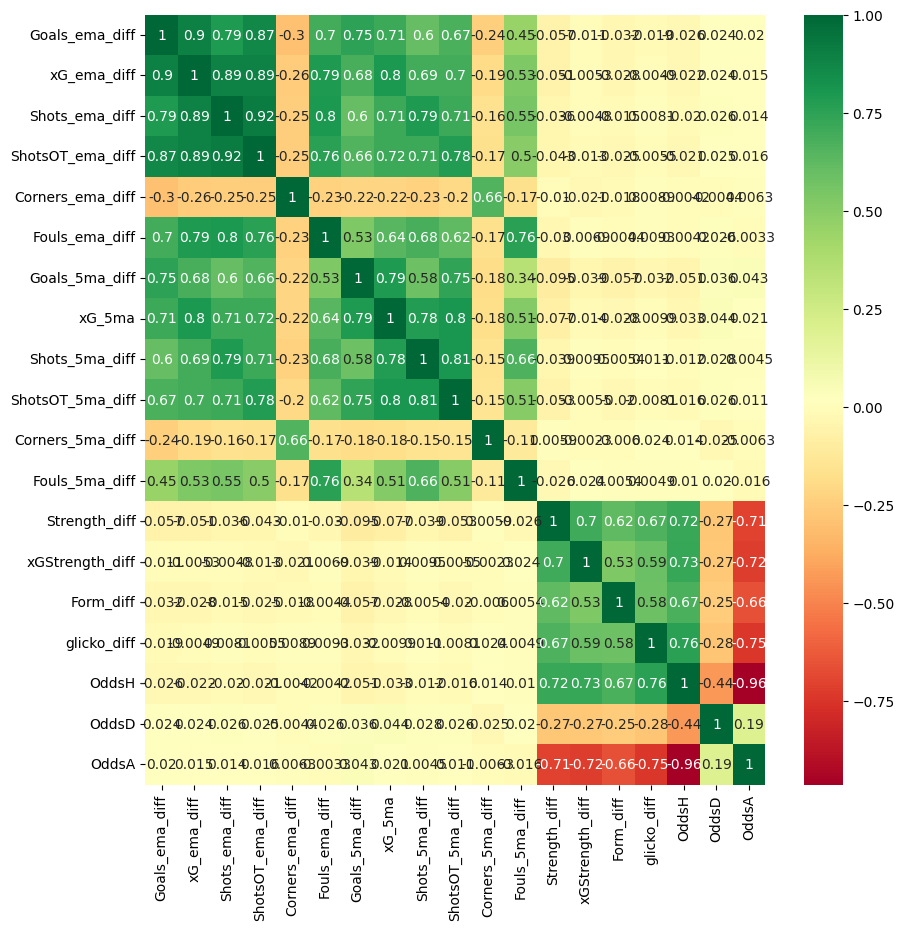

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = X_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(X_train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(BalancedRandomForestClassifier(), n_features_to_select='auto', direction = 'backward', scoring = 'f1_micro')
sfs.fit(X_train, y_train)

SequentialFeatureSelector(direction='backward',
                          estimator=BalancedRandomForestClassifier(),
                          n_features_to_select='auto', scoring='f1_micro')

In [ ]:
breytur = sfs.get_feature_names_out()
breytur

array(['Goals_ema_diff', 'ShotsOT_ema_diff', 'Corners_ema_diff',
       'Shots_5ma_diff', 'Corners_5ma_diff', 'Fouls_5ma_diff',
       'Strength_diff', 'Form_diff', 'OddsH', 'OddsA'], dtype=object)

In [ ]:
#til að muna
array(['Goals_ema_diff', 'ShotsOT_ema_diff', 'Corners_ema_diff',
       'Shots_5ma_diff', 'Corners_5ma_diff', 'Fouls_5ma_diff',
       'Strength_diff', 'Form_diff', 'OddsH', 'OddsA'], dtype=object)

In [ ]:
X_train = X_train.filter(breytur)
X_test = X_test.filter(breytur)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np


forest = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', random_state=42)
#forest = BalancedRandomForestClassifier(n_estimators=1000, random_state=42)

forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=500,
                       random_state=42)

In [ ]:
features = X_train.columns
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
indices
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,features[indices[f]], importances[indices[f]]))

 1) Strength_diff                  0.119863
 2) OddsA                          0.116353
 3) OddsH                          0.114079
 4) ShotsOT_ema_diff               0.106701
 5) Corners_ema_diff               0.101385
 6) Goals_ema_diff                 0.099209
 7) Shots_5ma_diff                 0.092609
 8) Fouls_5ma_diff                 0.088796
 9) Corners_5ma_diff               0.087754
10) Form_diff                      0.073251


In [ ]:
y_pred = forest.predict(X_test)

In [ ]:
y_pred

array([2, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0,
       0, 2, 0, 1, 0, 2, 0, 0, 1, 0, 1, 2, 1, 0, 0, 1, 2, 2, 0, 1, 0, 2,
       2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0,
       2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0,
       0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 1, 2, 2,
       0, 1, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2,
       0, 2, 0, 0, 1, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0,
       1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0,
       0, 1, 0, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 2,
       2, 1, 2, 2, 0, 0, 0, 0, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0,

In [ ]:
predictions = forest.predict_proba(X_test)

In [ ]:
predictions

array([[0.232, 0.292, 0.476],
       [0.268, 0.196, 0.536],
       [0.248, 0.466, 0.286],
       ...,
       [0.308, 0.428, 0.264],
       [0.702, 0.168, 0.13 ],
       [0.124, 0.228, 0.648]])

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.5185185185185185

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test, predictions)

1.0076462106650181

In [ ]:
X_df.isnull().any().any()

False

In [ ]:
odds = X_df[['OddsH','OddsA','OddsD']]
odds = odds.iloc[2212:2582]
odds_pred = odds.idxmax(axis=1).str[-1]
odds_pred = odds_pred.map({"H": 0, 'D': 1, "A": 2})

In [ ]:
odds_pred.isnull().any().any()

False

In [ ]:
odds = X_df[['OddsH','OddsA','OddsD']]
odds = odds.iloc[2212:2582]
odds_pred = odds.idxmax(axis=1).str[-1]
odds_pred = odds_pred.map({"H": 0, 'D': 1, "A": 2})
model_pred = forest.predict(X_test)

from sklearn.metrics import f1_score

casino_f1 = f1_score(y_test, odds_pred, average='macro')
model_f1 = f1_score(y_test, model_pred, average='macro')
improvement = (model_f1/casino_f1)-1

print("Overall Performance vs Casino:\n=============================")
print(f"casino f1 for these games: {casino_f1:.3f}, model f1: {model_f1:.3f}, skill increase = {improvement*100:.1f}%")
print(f"favorites are the same {(odds_pred==model_pred).mean()*100:.2f}% of the time")

Overall Performance vs Casino:
casino f1 for these games: 0.411, model f1: 0.410, skill increase = -0.1%
favorites are the same 83.19% of the time


In [ ]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve



forest_proba = forest.predict_proba(X_test)
data = [
    # truth, probabilities, labels
    (y_test=='H', forest_proba[:,0], 'Home Win'),
    (y_test=='D', forest_proba[:,1], 'Draw\t'),
    (y_test=='A', forest_proba[:,2], 'Away Win'),
]
print("forest Calibration Report:\n========================")
for i, y in enumerate(['Home','Draw','Away']):
    b_forest = brier_score_loss(y_test==y[0], forest_proba[:,i])
    b_casino = brier_score_loss(y_test==y[0], odds['Odds'+y[0]])
    print(f'{y} Brier Score\tCasino: {b_casino:.4f}\tforest: {b_forest:.4f}')

forest Calibration Report:
Home Brier Score	Casino: 0.2541	forest: 0.2352
Draw Brier Score	Casino: 0.0675	forest: 0.0667
Away Brier Score	Casino: 0.1448	forest: 0.1322


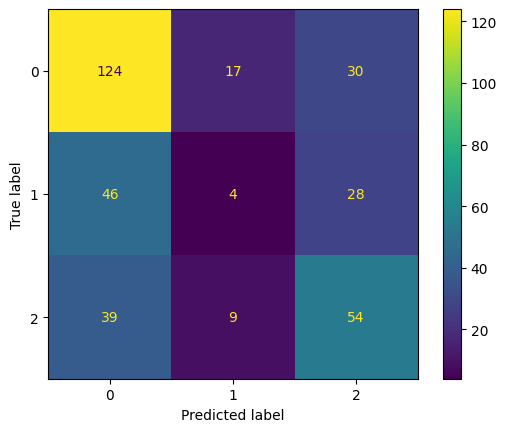

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(forest, X_test, y_test)
plt.show()

In [ ]:
#ok, bara ema virkar alls ekki... úr ítrun 1 (þetta er gamalt)
#betra þegar diff var notað og form bætt við. ítrun 2
#eitthvað til að skoða, odds bætt við? gengur illa að spá fyrir um jafntefli. ítrun 3
#gæti prófað að bæta við að ef forestinn er mjög óviss um sigurvegara að láta hann bara spá jafntefli.
#td ef hann nær ekki upp í 40% proba er öruggara að spá x.
#ítrun 5, balanced random forest classifier, virkar vel
#https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html

In [ ]:
from sklearn.model_selection import RandomizedSearchCV as RSCV

param_grid = {'n_estimators':np.arange(50,1000,10),
              'max_features': ['auto', 'sqrt', 'log2'],
              #'max_depth' :np.arange(20,200,5),
              'max_samples': [0.2, 0.4, 0.6, 0.8, 1]}

modelbrf = BalancedRandomForestClassifier()

model = RSCV(modelbrf, param_grid, n_iter = 20,
             n_jobs = -1, random_state=42).fit(X_train, y_train)
model.fit(X_train, y_train)

# Get the best hyperparameters
best_params = model.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 160, 'max_samples': 0.2, 'max_features': 'sqrt'}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
import numpy as np


# Define the hyperparameter distribution
param_dist = {
    'n_estimators': np.arange(50, 1000, 25),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': np.arange(2, 11, 2),
    'max_samples': [0.2, 0.4, 0.6, 0.8, 1]
}

# Create the BRF model
brf = BalancedRandomForestClassifier()

# Define a custom scorer based on micro-averaged F1 score
scorer = make_scorer(f1_score, average='micro')

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=brf, param_distributions=param_dist,
                                   scoring=scorer, n_iter=20, random_state=42, n_jobs=-1)

# Fit the model to the data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model on a separate test set
test_f1_micro = random_search.best_estimator_.score(X_test, y_test)
print("Test F1 Micro:", test_f1_micro)


Best Hyperparameters: {'n_estimators': 575, 'min_samples_split': 10, 'max_samples': 0.2, 'max_features': 'auto', 'max_depth': 25}
Test F1 Micro: 0.49572649572649574


In [ ]:
#model_salka_rfv1 = model
model_salka_rfv1 = BalancedRandomForestClassifier(**best_params)

In [ ]:
# þjálfum þá þetta módel og notum það til að spá.
model_salka_rfv1_fitted = model_salka_rfv1.fit(X_train, y_train)

In [ ]:
y_pred = model_salka_rfv1_fitted.predict(X_test)
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.5014245014245015

In [ ]:
preds = model_salka_rfv1.predict_proba(X_test)

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test, preds)

1.0218584668918427

In [ ]:
odds = X_df[['OddsH','OddsA','OddsD']]
odds = odds.iloc[2212:2582]
odds_pred = odds.idxmax(axis=1).str[-1]
odds_pred = odds_pred.map({"H": 0, 'D': 1, "A": 2})
model_pred = model_salka_rfv1.predict(X_test)

In [ ]:
from sklearn.metrics import f1_score

casino_f1 = f1_score(y_test, odds_pred, average='macro')
model_f1 = f1_score(y_test, model_pred, average='macro')
improvement = (model_f1/casino_f1)-1

In [ ]:
print("Overall Performance vs Casino:\n=============================")
print(f"casino f1 for these games: {casino_f1:.3f}, model f1: {model_f1:.3f}, skill increase = {improvement*100:.1f}%")
print(f"favorites are the same {(odds_pred==model_pred).mean()*100:.2f}% of the time")

Overall Performance vs Casino:
casino f1 for these games: 0.411, model f1: 0.480, skill increase = 16.9%
favorites are the same 65.53% of the time


In [ ]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve



model_salka_rfv1_proba = model_salka_rfv1.predict_proba(X_test)
data = [
    # truth, probabilities, labels
    (y_test=='H', model_salka_rfv1_proba[:,0], 'Home Win'),
    (y_test=='D', model_salka_rfv1_proba[:,1], 'Draw\t'),
    (y_test=='A', model_salka_rfv1_proba[:,2], 'Away Win'),
]
print("model_salka_rfv1 Calibration Report:\n========================")
for i, y in enumerate(['Home','Draw','Away']):
    b_model_salka_rfv1 = brier_score_loss(y_test==y[0], model_salka_rfv1_proba[:,i])
    b_casino = brier_score_loss(y_test==y[0], odds['Odds'+y[0]])
    print(f'{y} Brier Score\tCasino: {b_casino:.4f}\tmodel_salka_rfv1: {b_model_salka_rfv1:.4f}')

model_salka_rfv1 Calibration Report:
Home Brier Score	Casino: 0.2541	model_salka_rfv1: 0.1493
Draw Brier Score	Casino: 0.0675	model_salka_rfv1: 0.1195
Away Brier Score	Casino: 0.1448	model_salka_rfv1: 0.1273


Hér vista ég útgáfu 1 af sölku sem er núna kandídat í

In [ ]:
import pickle

#vista þetta sem ready for prediction, allavega V1
pick_insert = open('drive/My Drive/model_salka_balancedrfv1.pickle','wb')
pickle.dump(model_salka_rfv1, pick_insert)
pick_insert.close()

In [ ]:
import pickle

pick_read = open('drive/My Drive/model_salka_balancedrfv1.pickle','rb')
model_salka_rfv1 = pickle.load(pick_read)
pick_read.close()

In [ ]:
features = X_train.columns
importances = model_salka_rfv1.feature_importances_

indices = np.argsort(importances)[::-1]
indices
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,features[indices[f]], importances[indices[f]]))

 1) OddsH                          0.216276
 2) OddsA                          0.190696
 3) xGStrength_diff                0.150614
 4) OddsD                          0.083278
 5) Form_diff                      0.066610
 6) ShotsOT_ema_diff               0.055846
 7) xG_ema_diff                    0.051733
 8) Fouls_ema_diff                 0.049133
 9) Shots_ema_diff                 0.047110
10) Goals_ema_diff                 0.046438
11) Corners_ema_diff               0.042266


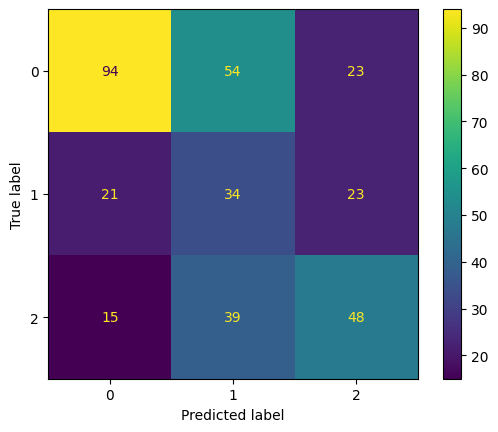

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(model_salka_rfv1, X_test, y_test)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.55      0.62       171
           1       0.27      0.44      0.33        78
           2       0.51      0.47      0.49       102

    accuracy                           0.50       351
   macro avg       0.50      0.49      0.48       351
weighted avg       0.56      0.50      0.52       351



In [ ]:
import numpy
unique, counts = numpy.unique(y_pred, return_counts=True)

dict(zip(unique, counts))

{0: 130, 1: 127, 2: 94}

Skoða nú hversu vel módelið stóð sig.

In [ ]:
Studlar = df_ready.filter(['OddsH', 'OddsD', 'OddsA'
                        ], axis=1)

#Studlar = Studlar.iloc[2204:2570] #spain
Studlar = Studlar.iloc[2212:2582] #uk
Studlar['BookiePrediction'] = Studlar.idxmax(axis=1)
Studlar = Studlar.replace({'OddsH': 0, 'OddsD': 1, 'OddsA': 2})

#filterum nokkra lýsandi dálka
Leikir = df_ready.filter(['GameId', 'HomeTeam','AwayTeam','HomeGoals','AwayGoals',
                          'winner','OddsH', 'OddsD', 'OddsA'
                        ], axis=1)

#Leikir = Leikir.iloc[2204:2570] #spain
Leikir = Leikir.iloc[2212:2582] #uk

Studlar['winner'] = Leikir['winner']
Leikir['SalkaPrediction'] = y_pred #x_test spá að ofan, spá sölku á test setti

In [ ]:
def model_checker_bookie (df):

    Result = df['winner']

    Model_prediction = df['BookiePrediction']

    if Result == Model_prediction:
        model_correct = 1
    else:
        model_correct = 0

    return model_correct

In [ ]:
Studlar = Studlar.assign(BookieCorrect = Studlar.apply(model_checker_bookie, axis=1))

In [ ]:
def model_checker_salka (Leikir):

    Result = Leikir['winner']

    Model_prediction = Leikir['SalkaPrediction']

    if Result == Model_prediction:
        model_correct = 1
    else:
        model_correct = 0

    return model_correct

In [ ]:
Leikir = Leikir.assign(SalkaCorrect = Leikir.apply(model_checker_salka, axis=1))

In [ ]:
Leikir['BookieCorrect'] = Studlar['BookieCorrect']
Leikir['Total Matches'] = np.where(Leikir.index.notnull(),1,0)

Leikir_plot1 = Leikir.agg({'BookieCorrect':sum, 'SalkaCorrect':sum,
                                         'Total Matches':sum})

In [ ]:
Leikir_plot1

BookieCorrect    199
SalkaCorrect     176
Total Matches    351
dtype: int64

In [ ]:
def pay_out (Leikir):

    Result = Leikir['winner']
    Model_score = Leikir['SalkaCorrect']

    #Payout for a $10 bet
    #converta í odds úr prob
    for x in ['OddsH','OddsD','OddsA']:
      Leikir[x]=1/Leikir[x]

    home_win_payout = 10*(Leikir['OddsH'] - 1)
    draw_payout = 10*(Leikir['OddsD'] - 1)
    home_loss_payout = 10*(Leikir['OddsA']-1)
    payout = []
    if Model_score == 1:
        if Result == 0:
            payout = home_win_payout
        elif Result == 1:
            payout = draw_payout
        elif Result == 2:
            payout = home_loss_payout
    else: payout = -10

    return payout

In [ ]:
Leikir = Leikir.assign(payOut = Leikir.apply(pay_out, axis=1))

In [ ]:
Res = Leikir['payOut'].cumsum()
Res

2212   -10.0
2213    -2.0
2214    23.0
2215    32.0
2216    36.0
        ... 
2558   -87.0
2559   -74.0
2560   -84.0
2561   -79.0
2562   -89.0
Name: payOut, Length: 351, dtype: float64

Populating the interactive namespace from numpy and matplotlib


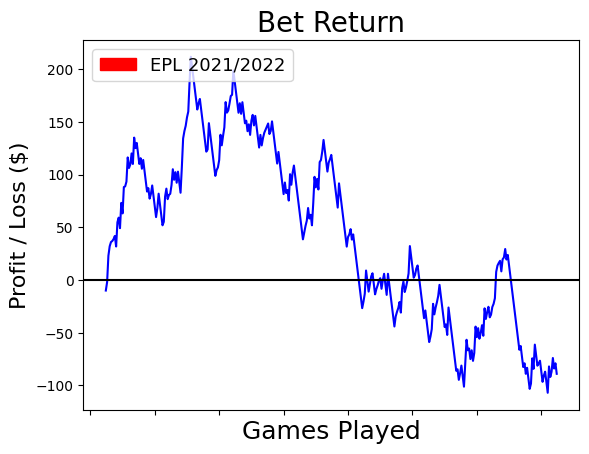

In [ ]:
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline
import matplotlib.patches as mpatches

Leikir['payOut'].cumsum().plot(linestyle='-', color='blue');

red_patch = mpatches.Patch(color='red', label='EPL 2021/2022')

plt.legend(handles=[red_patch],loc=2,prop={'size': 13})

plt.xlabel('Games Played', fontsize=18)
plt.ylabel('Profit / Loss ($)', fontsize=16)

plt.title("Bet Return", fontsize=20)

axhline(0, color='black')

# remove x axis ticks
plt.tick_params( axis='x',labelbottom=False)

plt.show;

In [ ]:
Strategy = Leikir['payOut']

In [ ]:
Net_Return = Strategy.sum()
Total_investments = len(Strategy)*10
Return_on_investment = 100*round((Net_Return / Total_investments),4)
print(f'{Return_on_investment}' + '%')

4.5600000000000005%


In [ ]:
Leikir['Probability_of_Home_Win'] = preds[:,0]
Leikir['Probability_of_Draw_Win'] = preds[:,1]
Leikir['Probability_of_Home_Loss'] = preds[:,2]

In [ ]:
def model_higher_than_bookies (df):

    '''Returns a 1 if model predicted probability greater than bookies predicted probability for that result'''

    Model_Prediction = df['SalkaPrediction']

    if Model_Prediction == 0:
        if df['Probability_of_Home_Win'] >= df['OddsH']:
            return 1
        else:
            return 0
    if Model_Prediction == 1:
        if df['Probability_of_Draw_Win'] >= df['OddsD']:
            return 1
        else:
            return 0
    if Model_Prediction == 2:
        if df['Probability_of_Home_Loss'] >= df['OddsA']:
            return 1
        else:
            return 0

In [ ]:
Leikir = Leikir.assign(SalkaConfident = Leikir.apply(model_higher_than_bookies, axis=1))
Strategy1 = Leikir[Leikir['SalkaConfident']==1]

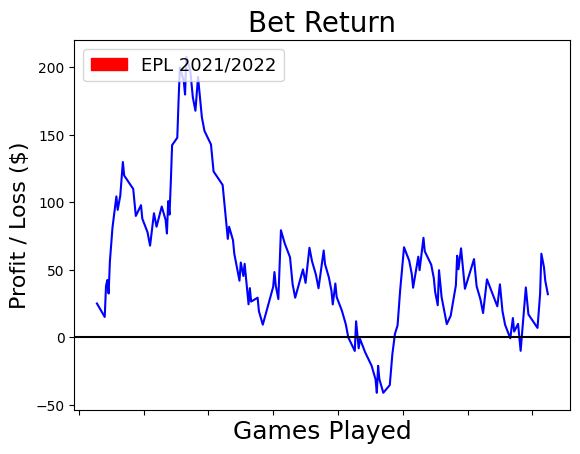

In [ ]:
Strategy1['payOut'].cumsum().plot(linestyle='-', color='blue');

red_patch = mpatches.Patch(color='red', label='EPL 2021/2022')

plt.legend(handles=[red_patch],loc=2,prop={'size': 13})

plt.xlabel('Games Played', fontsize=18)
plt.ylabel('Profit / Loss ($)', fontsize=16)

plt.title("Bet Return", fontsize=20)

axhline(0, color='black')

# remove x axis ticks
plt.tick_params( axis='x',labelbottom=False)

plt.show;

In [ ]:
Net_Return = Strategy1.payOut.sum()
Total_investments = len(Strategy1['payOut'])*10
Return_on_investment = 100*round((Net_Return / Total_investments),4)
print(f'{Return_on_investment}' + '%')

1.95%


In [ ]:
#Hér má segja að þetta endi eiginlega bara í draw betting.
Leikir_res= Leikir.agg({'BookieCorrect':sum, 'SalkaCorrect':sum,
                           'SalkaConfident':sum,'Total Matches':sum})
Leikir_res

BookieCorrect     199
SalkaCorrect      183
SalkaConfident    164
Total Matches     351
dtype: int64

In [ ]:
#þjálfum svo módelið aftur með nýja tímabilinu.

In [ ]:
import pickle

pick_read = open('drive/My Drive/model_salka_balancedrfv1.pickle','rb')
model_salka_rfv1 = pickle.load(pick_read)
pick_read.close()

model_salka_newest = model_salka_rfv1.fit(X_test, y_test)

In [ ]:
#vista þetta sem ready for prediction, allavega V1
pick_insert = open('drive/My Drive/model_salka_newest.pickle','wb')
pickle.dump(model_salka_newest, pick_insert)
pick_insert.close()

#nota þetta til að spá fyrir um 23/24 season. gaman að skoða muninn.

Prófum XGboost

In [ ]:
#splitta test og train
#UK
X_train = X_df.iloc[0:2212]
X_test = X_df.iloc[2212:2582]
y_train = y_df.iloc[0:2212]
y_test = y_df.iloc[2212:2582]
#Spain
#X_train = X_df.iloc[0:2204]
#X_test = X_df.iloc[2204:2570]
#y_train = y_df.iloc[0:2204]
#y_test = y_df.iloc[2204:2570]

Leikir = Leikir.iloc[2212:2582]

In [ ]:
X_test

,Goals_ema_diff,xG_ema_diff,Shots_ema_diff,ShotsOT_ema_diff,Corners_ema_diff,Fouls_ema_diff,Goals_5ma_diff,xG_5ma,Shots_5ma_diff,ShotsOT_5ma_diff,Corners_5ma_diff,Fouls_5ma_diff,Strength_diff,xGStrength_diff,Form_diff,glicko_diff,OddsH,OddsD,OddsA
2212,0.844971,0.820768,5.543789,1.339412,-1.054422,1.976269,1.2,0.969194,7.8,0.8,-3.4,0.4,-0.833333,-0.827886,-2,-481.932847,0.190476,0.230947,0.625000
2213,-0.185315,-0.234900,-0.804068,-0.582054,-0.964660,0.571669,0.8,-0.367471,-5.0,-1.8,-4.4,-2.6,0.285714,-0.146831,1,192.133087,0.238095,0.250000,0.555556
2214,-0.520959,-0.311510,-1.179286,-0.766197,0.926963,-0.084641,-1.2,-0.264676,-1.2,-0.6,1.6,0.4,1.100000,0.311976,3,535.713737,0.500000,0.285714,0.266667
2215,-0.044933,0.037601,1.092734,0.218242,-2.313197,0.466201,-0.4,0.060784,0.6,0.0,-5.2,-1.2,1.666667,0.584377,0,-0.988697,0.526316,0.263158,0.263158
2216,-0.039920,-0.558133,-4.748348,-1.147255,-1.212909,-2.191659,0.8,-0.763133,-8.8,-2.4,-2.8,-5.4,-0.025000,0.758772,3,483.242540,0.714286,0.200000,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2558,0.067143,-0.144571,-1.268377,-0.449946,-0.426211,-0.382989,-0.6,-0.972074,-3.8,-1.6,-1.0,-2.0,0.050376,0.100772,-1,-324.743046,0.666667,0.222222,0.153846
2559,0.536211,0.256620,1.268954,1.015219,-0.808056,0.325480,0.4,0.308850,2.0,1.8,-3.4,2.0,-0.429381,-0.415690,-2,-585.675144,0.363636,0.263158,0.434783
2560,-0.140763,-0.122863,-0.111974,-0.563331,-2.091900,1.779658,0.2,-0.404733,-0.2,0.0,-3.2,1.4,-0.042242,-0.144586,-3,-33.584483,0.523560,0.263158,0.277778
2561,-0.038148,-0.683390,-4.865574,-1.827267,0.637620,-0.652525,0.6,-1.221166,-10.0,-2.6,0.8,-1.6,0.274510,0.757955,2,73.719011,0.666667,0.230947,0.166667


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.datasets import make_classification

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'objective': ['multi:softmax'],
    'num_class': [3],
    'eval_metric': ['mlogloss'],
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'lambda': [0, 1, 2],
    'alpha': [0, 1, 2],
    'class_weight': ['balanced']  # Set class_weight to 'balanced'
}

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier(booster='gbtree', objective='multi:softmax', num_class=3, random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_dist, n_iter=10, scoring='neg_log_loss', random_state=42)
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_hyperparameters = random_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparameters)

# Evaluate the model on the test set
test_accuracy = random_search.best_estimator_.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Best Hyperparameters: {'subsample': 0.9, 'objective': 'multi:softmax', 'num_class': 3, 'min_child_weight': 5, 'max_depth': 3, 'lambda': 2, 'gamma': 0.1, 'eval_metric': 'mlogloss', 'eta': 0.1, 'colsample_bytree': 0.8, 'class_weight': 'balanced', 'alpha': 0}
Test Accuracy: 0.5413105413105413


In [ ]:
import xgboost as xgb

# Create an XGBoost classifier with the best hyperparameters
xgb_classifier = xgb.XGBClassifier(**best_hyperparameters, booster='gbtree', random_state=42)


In [ ]:
xgb_classifier.fit(X_train, y_train)

XGBClassifier(alpha=0, base_score=None, booster='gbtree', callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, device=None,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric='mlogloss', feature_types=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=2, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, ...)

In [ ]:
ypred = xgb_classifier.predict(X_test)

In [ ]:
ypred

array([2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2,
       0, 0, 0, 0, 2, 0, 2, 0, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 0, 1, 2, 2, 0, 0, 1, 2, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2,
       2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 2, 0, 2, 0, 1, 0,
       2, 0, 1, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0,
       0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2,
       0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       1, 0, 2, 2, 2, 2, 0, 2, 2, 0, 1, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 1, 2,
       2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 2, 0,

In [ ]:
print("Unique Values - Predictions:", np.unique(ypred), "Labels:", np.unique(y_test))

Unique Values - Predictions: [0 1 2] Labels: [0 1 2]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test, ypred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:\n", classification_report(y_test, ypred))

# Display confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, ypred))


Accuracy: 0.5413105413105413
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.74      0.67       171
           1       0.20      0.05      0.08        78
           2       0.47      0.58      0.52       102

    accuracy                           0.54       351
   macro avg       0.43      0.46      0.43       351
weighted avg       0.48      0.54      0.50       351

Confusion Matrix:
 [[127  11  33]
 [ 41   4  33]
 [ 38   5  59]]


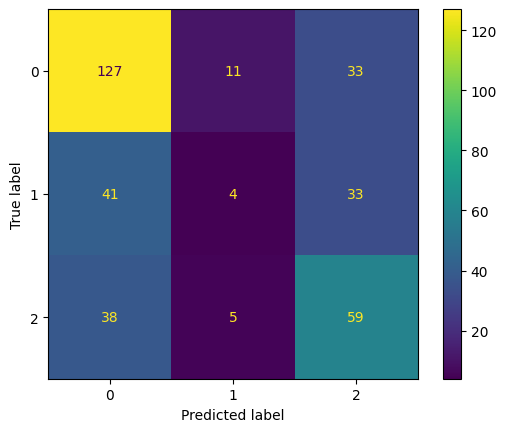

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, ypred)
plt.show()

In [ ]:
phfrom sklearn.metrics import classification_report
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.62      0.74      0.67       171
           1       0.20      0.05      0.08        78
           2       0.47      0.58      0.52       102

    accuracy                           0.54       351
   macro avg       0.43      0.46      0.43       351
weighted avg       0.48      0.54      0.50       351



In [ ]:
odds = X_test[['OddsH','OddsA','OddsD']]
odds_pred = odds.idxmax(axis=1).str[-1]
odds_pred = odds_pred.map({"H": 0, 'D': 1, "A": 2})
model_pred = modeltuned.predict(X_test)

KeyError: ignored

In [ ]:
from sklearn.metrics import f1_score
casino_f1 = f1_score(y_test, odds_pred, average='macro')
model_f1 = f1_score(y_test, model_pred, average='macro')
improvement = (model_f1/casino_f1)-1

In [ ]:
print("Overall Performance vs Casino:\n=============================")
print(f"casino f1 for these games: {casino_f1:.3f}, model f1: {model_f1:.3f}, skill increase = {improvement*100:.1f}%")
print(f"favorites are the same {(odds_pred==model_pred).mean()*100:.2f}% of the time")

Overall Performance vs Casino:
casino f1 for these games: 0.404, model f1: 0.491, skill increase = 21.4%
favorites are the same 70.00% of the time


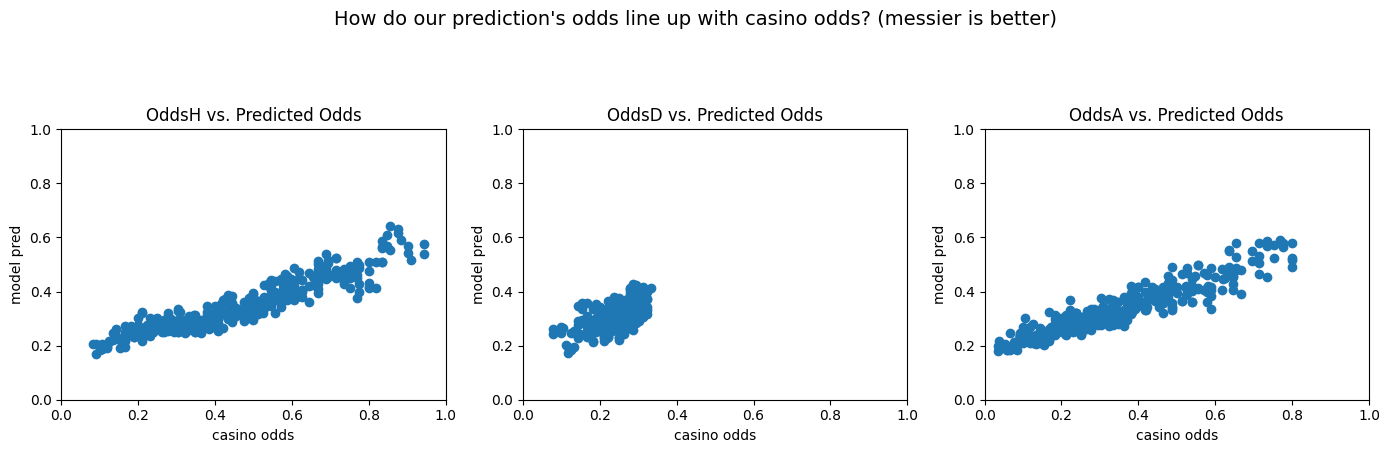

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
for i,j in enumerate(['OddsH','OddsD','OddsA']):
    x = odds[j]
    y = modeltuned.predict_proba(X_test)[:,i]
    ax[i].scatter(x,y)
    ax[i].set_ylabel('model pred')
    ax[i].set_xlabel('casino odds')
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(0,1)
    ax[i].title.set_text(j + ' vs. Predicted Odds')
fig.suptitle("How do our prediction's odds line up with casino odds? (messier is better)", fontsize=14, y=1.12)
fig.tight_layout()

In [ ]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve



model_proba = modeltuned.predict_proba(X_test)
data = [
    # truth, probabilities, labels
    (y_test=='H', model_proba[:,0], 'Home Win'),
    (y_test=='D', model_proba[:,1], 'Draw\t'),
    (y_test=='A', model_proba[:,2], 'Away Win'),
]
print("Model Calibration Report:\n========================")
for i, y in enumerate(['Home','Draw','Away']):
    b_model = brier_score_loss(y_test==y[0], model_proba[:,i])
    b_casino = brier_score_loss(y_test==y[0], odds['Odds'+y[0]])
    print(f'{y} Brier Score\tCasino: {b_casino:.4f}\tModel: {b_model:.4f}')

Model Calibration Report:
Home Brier Score	Casino: 0.2543	Model: 0.1304
Draw Brier Score	Casino: 0.0674	Model: 0.1065
Away Brier Score	Casino: 0.1455	Model: 0.1161


In [ ]:
#Vistum xgboost líkan

Populating the interactive namespace from numpy and matplotlib


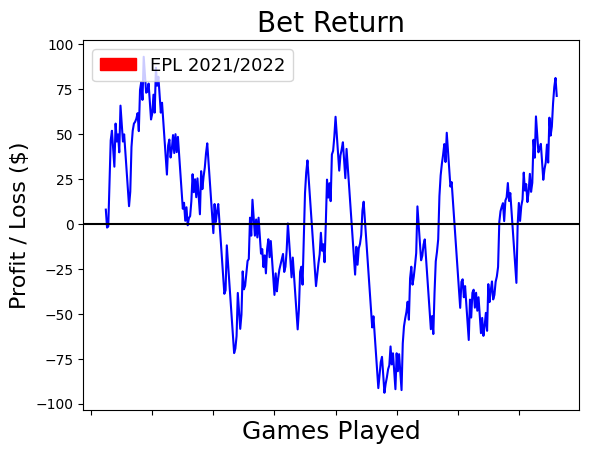

In [ ]:
Studlar = df_ready.filter(['OddsH', 'OddsD', 'OddsA'
                        ], axis=1)

Studlar = Studlar.iloc[2204:2570] #spain
#Studlar = Studlar.iloc[2212:2582] #uk
Studlar['BookiePrediction'] = Studlar.idxmax(axis=1)
Studlar = Studlar.replace({'OddsH': 0, 'OddsD': 1, 'OddsA': 2})

#filterum nokkra lýsandi dálka
Leikir = df_ready.filter(['GameId', 'HomeTeam','AwayTeam','HomeGoals','AwayGoals',
                          'winner','OddsH', 'OddsD', 'OddsA'
                        ], axis=1)

#Leikir = Leikir.iloc[2204:2570] #spain
Leikir = Leikir.iloc[2212:2582] #uk

Studlar['winner'] = Leikir['winner']
Leikir['SalkaPrediction'] = y_pred #x_test spá að ofan, spá sölku á test setti

def model_checker_bookie (df):

    Result = df['winner']

    Model_prediction = df['BookiePrediction']

    if Result == Model_prediction:
        model_correct = 1
    else:
        model_correct = 0

    return model_correct

Studlar = Studlar.assign(BookieCorrect = Studlar.apply(model_checker_bookie, axis=1))

def model_checker_salka (Leikir):

    Result = Leikir['winner']

    Model_prediction = Leikir['SalkaPrediction']

    if Result == Model_prediction:
        model_correct = 1
    else:
        model_correct = 0

    return model_correct

Leikir = Leikir.assign(SalkaCorrect = Leikir.apply(model_checker_salka, axis=1))

Leikir['BookieCorrect'] = Studlar['BookieCorrect']
Leikir['Total Matches'] = np.where(Leikir.index.notnull(),1,0)

Leikir_plot1 = Leikir.agg({'BookieCorrect':sum, 'SalkaCorrect':sum,
                                         'Total Matches':sum})

def pay_out (Leikir):

    Result = Leikir['winner']
    Model_score = Leikir['SalkaCorrect']

    #Payout for a $10 bet
    #converta í odds úr prob
    for x in ['OddsH','OddsD','OddsA']:
      Leikir[x]=1/Leikir[x]

    home_win_payout = 10*(Leikir['OddsH'] - 1)
    draw_payout = 10*(Leikir['OddsD'] - 1)
    home_loss_payout = 10*(Leikir['OddsA']-1)

    if Model_score == 1:
        if Result == 0:
            payout = home_win_payout
        elif Result == 1:
            payout = draw_payout
        elif Result == 2:
            payout = home_loss_payout
    else: payout = -10

    return payout

Leikir = Leikir.assign(payOut = Leikir.apply(pay_out, axis=1))

import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline
import matplotlib.patches as mpatches

Leikir['payOut'].cumsum().plot(linestyle='-', color='blue');

red_patch = mpatches.Patch(color='red', label='EPL 2021/2022')

plt.legend(handles=[red_patch],loc=2,prop={'size': 13})

plt.xlabel('Games Played', fontsize=18)
plt.ylabel('Profit / Loss ($)', fontsize=16)

plt.title("Bet Return", fontsize=20)

axhline(0, color='black')

# remove x axis ticks
plt.tick_params( axis='x',labelbottom=False)

plt.show;

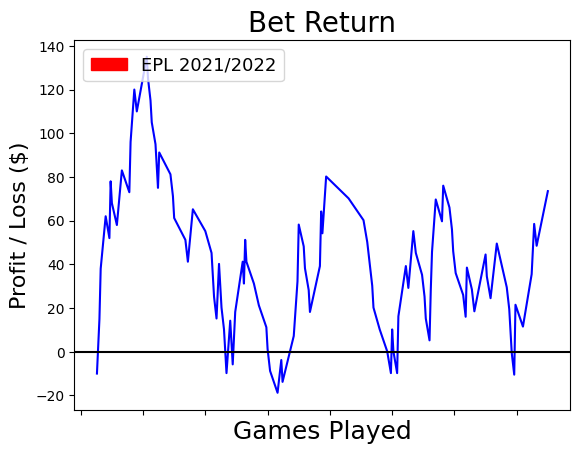

In [ ]:
Leikir['Probability_of_Home_Win'] = model_proba[:,0]
Leikir['Probability_of_Draw_Win'] = model_proba[:,1]
Leikir['Probability_of_Home_Loss'] = model_proba[:,2]

def model_higher_than_bookies (df):

    '''Returns a 1 if model predicted probability greater than bookies predicted probability for that result'''

    Model_Prediction = df['SalkaPrediction']

    if Model_Prediction == 0:
        if df['Probability_of_Home_Win'] >= df['OddsH']:
            return 1
        else:
            return 0
    if Model_Prediction == 1:
        if df['Probability_of_Draw_Win'] >= df['OddsD']:
            return 1
        else:
            return 0
    if Model_Prediction == 2:
        if df['Probability_of_Home_Loss'] >= df['OddsA']:
            return 1
        else:
            return 0

Leikir = Leikir.assign(SalkaConfident = Leikir.apply(model_higher_than_bookies, axis=1))
Strategy1 = Leikir[Leikir['SalkaConfident']==1]

Strategy1['payOut'].cumsum().plot(linestyle='-', color='blue');

red_patch = mpatches.Patch(color='red', label='EPL 2021/2022')

plt.legend(handles=[red_patch],loc=2,prop={'size': 13})

plt.xlabel('Games Played', fontsize=18)
plt.ylabel('Profit / Loss ($)', fontsize=16)

plt.title("Bet Return", fontsize=20)

axhline(0, color='black')

# remove x axis ticks
plt.tick_params( axis='x',labelbottom=False)

plt.show;

nú vandar að finna bet stratergy en líka skoða hvernig gengur yfir alla leiki. Spreyta sig á neural network. Langar lika í enn meira af gögnum, þarf að skrapa fbref, erfitt samt.

In [ ]:
#Prófa aðeins KNN

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import math
#The value of k is non-parametric and a general rule of thumb in
#choosing the value of k
#is k = sqrt(N)/2, where N stands for
#the number of samples in your training dataset.
N = len(X_train)
k_gisk = round(math.sqrt(N)/2)
print(k_gisk)

knn = KNeighborsClassifier(n_neighbors = k_gisk)
knn.fit(X_train_scaled, y_train)

24


KNeighborsClassifier(n_neighbors=24)

In [ ]:
knn.score(X_train_scaled, y_train)

0.5723327305605787

In [ ]:
knn.score(X_test_scaled, y_test)

0.5297297297297298

In [ ]:
y_pred = knn.predict(X_test_scaled)

In [ ]:
training_accuracy  = []
test_accuracy = []
for i in range(1, 47):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train_scaled, y_train)
    training_accuracy.append(knn.score(X_train_scaled, y_train))
    test_accuracy.append(knn.score(X_test_scaled, y_test))

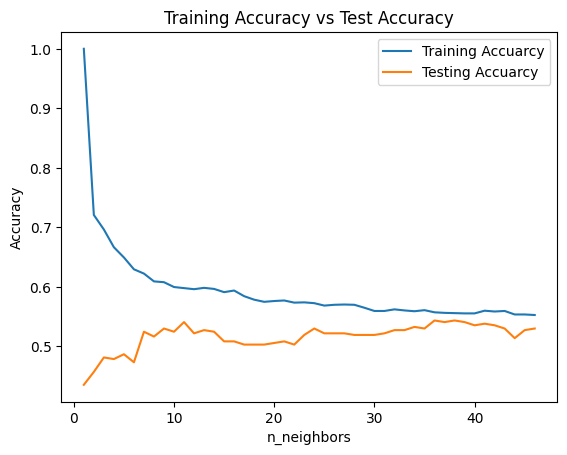

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, 47), training_accuracy, label='Training Accuarcy')
plt.plot(range(1, 47), test_accuracy, label='Testing Accuarcy')
plt.title('Training Accuracy vs Test Accuracy')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
#spáir betur með 23 en þetta?
knn = KNeighborsClassifier(n_neighbors = 37)
knn.fit(X_train_scaled, y_train)
score_train= knn.score(X_train_scaled, y_train)
score_test = knn.score(X_test_scaled, y_test)
y_pred = knn.predict(X_test_scaled)

In [ ]:
print(score_train)
print(score_test)
#nokkuð gott, getum alveg notað knn fyrir næsta tímabil

0.5560578661844484
0.5405405405405406


In [ ]:
#knn með full data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_df_scaled = scaler.fit_transform(X_df)

knn_full = KNeighborsClassifier(n_neighbors = 41)
knn_full.fit(X_df_scaled, y_df)

knn.score(X_df_scaled, y_df)

#vistum svo þennan knn sem fullgildan spáaðila

import pickle

#vista þetta sem ready for prediction, allavega V1
pick_insert = open('drive/My Drive/model_salka_knn.pickle','wb')
pickle.dump(knn_full, pick_insert)
pick_insert.close()

pick_read = open('drive/My Drive/model_salka_knn.pickle','rb')
model_salka_knn = pickle.load(pick_read)
pick_read.close()

In [ ]:
y_pred

array([0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 2, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0,
       1, 0, 0, 2, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0,
       1, 0, 2, 0, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 2, 2, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2,
       0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2,
       0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 1, 0, 1, 0, 0, 0,
       1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2,
       1, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 2, 1, 2, 0, 1, 2, 0, 0, 0, 2, 2, 0, 1, 2, 2, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0,

In [ ]:
import numpy
unique, counts = numpy.unique(y_pred, return_counts=True)

dict(zip(unique, counts))

{0: 226, 1: 23, 2: 121}

Populating the interactive namespace from numpy and matplotlib


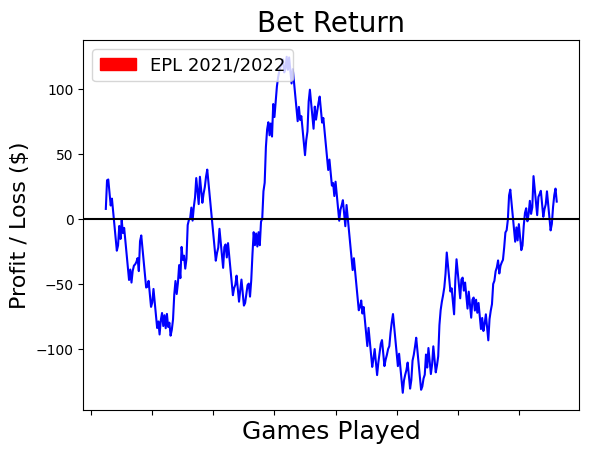

In [ ]:
Studlar = df_ready.filter(['OddsH', 'OddsD', 'OddsA'
                        ], axis=1)

#Studlar = Studlar.iloc[2204:2570] #spain
Studlar = Studlar.iloc[2212:2582] #uk
Studlar['BookiePrediction'] = Studlar.idxmax(axis=1)
Studlar = Studlar.replace({'OddsH': 0, 'OddsD': 1, 'OddsA': 2})

#filterum nokkra lýsandi dálka
Leikir = df_ready.filter(['GameId', 'HomeTeam','AwayTeam','HomeGoals','AwayGoals',
                          'winner','OddsH', 'OddsD', 'OddsA'
                        ], axis=1)

#Leikir = Leikir.iloc[2204:2570] #spain
Leikir = Leikir.iloc[2212:2582] #uk

Studlar['winner'] = Leikir['winner']
Leikir['SalkaPrediction'] = y_pred #x_test spá að ofan, spá sölku á test setti

def model_checker_bookie (df):

    Result = df['winner']

    Model_prediction = df['BookiePrediction']

    if Result == Model_prediction:
        model_correct = 1
    else:
        model_correct = 0

    return model_correct

Studlar = Studlar.assign(BookieCorrect = Studlar.apply(model_checker_bookie, axis=1))

def model_checker_salka (Leikir):

    Result = Leikir['winner']

    Model_prediction = Leikir['SalkaPrediction']

    if Result == Model_prediction:
        model_correct = 1
    else:
        model_correct = 0

    return model_correct

Leikir = Leikir.assign(SalkaCorrect = Leikir.apply(model_checker_salka, axis=1))

Leikir['BookieCorrect'] = Studlar['BookieCorrect']
Leikir['Total Matches'] = np.where(Leikir.index.notnull(),1,0)

Leikir_plot1 = Leikir.agg({'BookieCorrect':sum, 'SalkaCorrect':sum,
                                         'Total Matches':sum})

def pay_out (Leikir):

    Result = Leikir['winner']
    Model_score = Leikir['SalkaCorrect']

    #Payout for a $10 bet
    #converta í odds úr prob
    for x in ['OddsH','OddsD','OddsA']:
      Leikir[x]=1/Leikir[x]

    home_win_payout = 10*(Leikir['OddsH'] - 1)
    draw_payout = 10*(Leikir['OddsD'] - 1)
    home_loss_payout = 10*(Leikir['OddsA']-1)

    if Model_score == 1:
        if Result == 0:
            payout = home_win_payout
        elif Result == 1:
            payout = draw_payout
        elif Result == 2:
            payout = home_loss_payout
    else: payout = -10

    return payout

Leikir = Leikir.assign(payOut = Leikir.apply(pay_out, axis=1))

import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline
import matplotlib.patches as mpatches

Leikir['payOut'].cumsum().plot(linestyle='-', color='blue');

red_patch = mpatches.Patch(color='red', label='EPL 2021/2022')

plt.legend(handles=[red_patch],loc=2,prop={'size': 13})

plt.xlabel('Games Played', fontsize=18)
plt.ylabel('Profit / Loss ($)', fontsize=16)

plt.title("Bet Return", fontsize=20)

axhline(0, color='black')

# remove x axis ticks
plt.tick_params( axis='x',labelbottom=False)

plt.show;


In [ ]:
#prófa home win lr módel
